In [1]:
# data downloaded from:
# https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE92742
# CMAP data User Guide: 
# https://docs.google.com/document/d/1q2gciWRhVCAAnlvF2iRLuJ7whrGP6QjpsCMq1yWz7dU/

from support_functions import log_progress, clean_drugbank, query_chembl

import pandas as pd
import numpy as np
import itertools
from cmapPy.pandasGEXpress import parse
import requests

# plotting
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid", color_codes=True)

___
# Predicting drug targets from gene expression perturbation signatures<br>

### (Very) Brief background on drug discovery

Many medicinal drugs are small molecules that bind to specific proteins in your body and inihibit their function. This can have a variety of network-level effects depending on the target protein. In many cases the disease involves protein interactions that are happening "too much", and the inhibitor, by binding to the protein, has the effect of "slowing down" the interaction or preventing it entirely.

Historically, drugs have been discovered by chance. High throughput screens test thousands of drugs and those that produce the desired outcome in *in-vitro* assays are selected for further development. Often, drugs' specific target protein(s) are not known a-priori, and this can lead to side-effects and toxicity later down the line when the drugs are tested in live animals. Being able to predict which specific proteins a bioactive compound will bind to and inhibit has immense potential to accelerate drug discovery and drug repurposing.

### Leveraging "big data" to predict drug-target interactions

Today we're witnessing an explosion of publicly available biological data through initiatives like the 1000 Genomes Project, The Cancer Genome Atlas, and the NIH's Library of Integrated Network-Based Cellular Signatures (LINCS) Program. The LINCS initiative generates and makes public gene expression data that indicates how different types of cells respond to various genetic and environmental perturbations, including drugs. 

Gene expression regulation in human cells is a complex and noisy process, making it difficult to determine the protein target of a drug by looking at which genes in the cell are up/down regulated as a result of drug treatment. However, here we hypothesize that a cell treated with an small molecule inhibitor for a given protein should produce a similar gene expression profile to that of an untreated cell in which the gene coding for that protein has been silenced.

LINCS contains gene expression profiles for over 20,000 small molecule/drug treatments and over 20,000 gene silencing, or "knockdown" experiments. We know the protein targets of many of the drugs that are tested, and some of these proteins were knocked down in separate experiments. So, we can test our hypothesis by triyng to build a machine learning classifier to predict whether a drug and a protein interact by looking at the gene expression profiles from their corresponding treatment and knockdown experiments.

If our classifier works, we can use it to predict targets for new drugs by comparing the drug's expression profiles against all the knockdown profiles in LINCS.

___
## Import LINCS Phase 1 MetaData

In [2]:
# cell line information
cell_info_1 = pd.read_csv('data/GSE92742_Broad_LINCS_cell_info.txt', sep='\t', header=0)
# primary gene symbols and IDs
gene_info_1 = pd.read_csv('data/GSE92742_Broad_LINCS_gene_info.txt', sep='\t', header=0)
# landmark genes
gene_into_delta_lm_1 = pd.read_csv('data/GSE92742_Broad_LINCS_gene_info_delta_landmark.txt', sep='\t', header=0)
# Metadata pertaining to individual profiles (or instances, experiments) 
inst_info_1 = pd.read_csv('data/GSE92742_Broad_LINCS_inst_info.txt', sep='\t', header=0, dtype={'pert_dose_unit': str})
# Metadata describing each perturbagen used in experiments (pert_id)
pert_info_1 = pd.read_csv('data/GSE92742_Broad_LINCS_pert_info.txt', sep='\t', header=0)
# Calculated / derived / inferred metrics and annotations associated with each perturbagen that was used in the experiments.
pert_metrics_1 = pd.read_csv('data/GSE92742_Broad_LINCS_pert_metrics.txt', sep='\t', header=0)
# Metadata for signatures of aggregated replicates (level 5 data)
sig_info_1 = pd.read_csv('data/GSE92742_Broad_LINCS_sig_info.txt', sep='\t', header=0, dtype={'pert_dose': float})
# Calculated / derived / inferred metrics and annotations associated with each signature in the Level 5 matrix
sig_metrics_1 = pd.read_csv('data/GSE92742_Broad_LINCS_sig_metrics.txt', sep='\t', header=0)

## Import LINCS Phase 2 MetaData

In [3]:
# cell line information
cell_info_2 = pd.read_csv('data/GSE70138_Broad_LINCS_cell_info_2017-04-28.txt', sep='\t', header=0)
# primary gene symbols and IDs
gene_info_2 = pd.read_csv('data/GSE70138_Broad_LINCS_gene_info_2017-03-06.txt', sep='\t', header=0)
# Metadata pertaining to individual profiles (or instances, experiments) 
inst_info_2 = pd.read_csv('data/GSE70138_Broad_LINCS_inst_info_2017-03-06.txt', sep='\t', header=0, dtype={'pert_dose_unit': str})
# Metadata describing each perturbagen used in experiments (pert_id)
pert_info_2a = pd.read_csv('data/GSE70138_Broad_LINCS_pert_info.txt', sep='\t', header=0)
# Calculated / derived / inferred metrics and annotations associated with each perturbagen that was used in the experiments.
pert_info_2b = pd.read_csv('data/GSE70138_Broad_LINCS_pert_info_2017-03-06.txt', sep='\t', header=0)
# Metadata for signatures of aggregated replicates (level 5 data)
sig_info_2 = pd.read_csv('data/GSE70138_Broad_LINCS_sig_info_2017-03-06.txt', sep='\t', header=0, dtype={'pert_dose': float})
# Calculated / derived / inferred metrics and annotations associated with each signature in the Level 5 matrix
sig_metrics_2 = pd.read_csv('data/GSE70138_Broad_LINCS_sig_metrics_2017-03-06.txt', sep='\t', header=0)

## Combine Phase 1 and Phase 2 data

In [11]:
pert_info = pd.concat([pert_info_1, pert_info_2a], ignore_index=True)
sig_info = pd.concat([sig_info_1, sig_info_2], ignore_index=True)
sig_metrics = pd.concat([sig_metrics_1, sig_metrics_2], ignore_index=True)

## Identify landmark genes

In [5]:
lm_genes = gene_info_1[gene_info_1['pr_is_lm'].astype(bool)]
lm_gene_ids = lm_genes['pr_gene_id'].astype(str).values

## LINCS perturbation types

<br>The most common types of LINCS perturbations by far are small molecule compounds (trt_cp) and gene knockdowns (trt_sh).

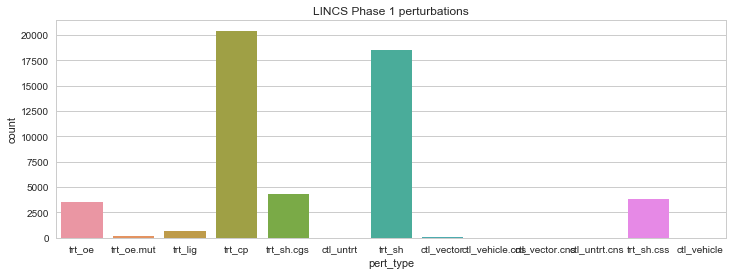

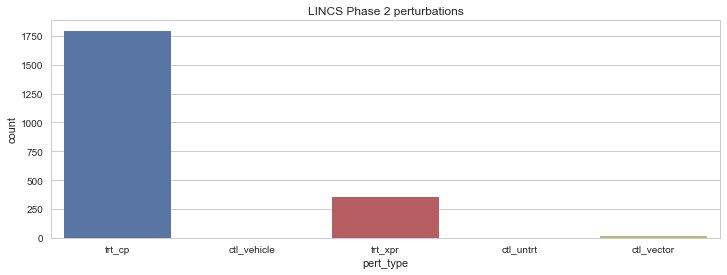

In [6]:
f, ax = plt.subplots(figsize=(12, 4))
sns.countplot(x="pert_type", data=pert_info_1)
plt.title("LINCS Phase 1 perturbations")
plt.show()

f, ax = plt.subplots(figsize=(12, 4))
sns.countplot(x="pert_type", data=pert_info_2a)
plt.title("LINCS Phase 2 perturbations")
plt.show()

## Checking TAS of our hits

In [10]:
# sns.distplot(all_sig_info[all_sig_info.pert_type == 'trt_cp'].tas)
# plt.show()

In [ ]:
# sns.distplot(all_sig_info[all_sig_info.pert_iname == 'wortmannin'].tas)
# plt.title('Wortmannin')
# plt.show()

# sns.distplot(all_sig_info[all_sig_info.pert_id == 'BRD-K20742498'].tas)
# plt.title('HRAS cpd')
# plt.show()

# sns.distplot(all_sig_info[all_sig_info.pert_id == 'BRD-K15563106'].tas)
# plt.title('KRAS cpd')
# plt.show()

# sns.distplot(all_sig_info[all_sig_info.pert_id == 'BRD-K19227686'].tas)
# plt.title('CHIP cpd 1')
# plt.show()

# sns.distplot(all_sig_info[all_sig_info.pert_id == 'BRD-K65503129'].tas)
# plt.title('CHIP cpd 2')
# plt.show()

# sns.distplot(all_sig_info[all_sig_info.pert_id == 'BRD-K29905972'].tas)
# plt.title('CHIP cpd 3')
# plt.show()

# sns.distplot(all_sig_info[all_sig_info.pert_id == 'BRD-K59556282'].tas)
# plt.title('CHIP cpd 4')
# plt.show()

## Refine scope to 'gold' perturbations

Due to redundancy in the LINCS dataset, we can ignore a lot of the low-quality data. We want to focus on **GOLD** signatures, meaning:<br><br>
*A heuristic for assessing whether a signature is reproducible and distinct. Requirements include: distil_cc_q75 >= 0.2 and pct_self_rank_q25 <= 0.05.*

- **icc**: Inter-cell connectivity (ICC). The similarity (aggregated WTCS) between signatures of a given perturbagen across cell lines. This number ranges between -1 and 1, and the higher the number, the more similar the signatures across cell lines. Only exemplar signatures are used in computing ICC. See is_exemplar for more details.
- **pct_self_rank_q25**:  Self connectivity of replicates expressed as a percentage of total instances in a replicate set.
- **distil_cc_q75**:  75th quantile of pairwise spearman correlations in landmark space of replicate level 4 profiles.



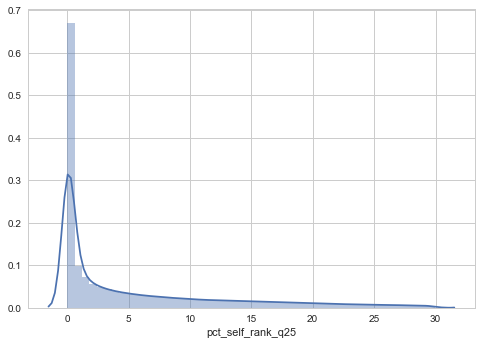

In [12]:
# n = 591697
all_sig_info = pd.concat([sig_info, sig_metrics[['distil_cc_q75', 'pct_self_rank_q25', 'tas']]], axis=1)
all_sig_info.to_csv('checkpoint_files/all_sig_info.csv')

pct_self_rank_sigs = all_sig_info[(all_sig_info.pct_self_rank_q25 > -1) &
                                  (all_sig_info.pct_self_rank_q25 < 30)
                                 ]
sns.distplot(pct_self_rank_sigs.pct_self_rank_q25);
plt.show()

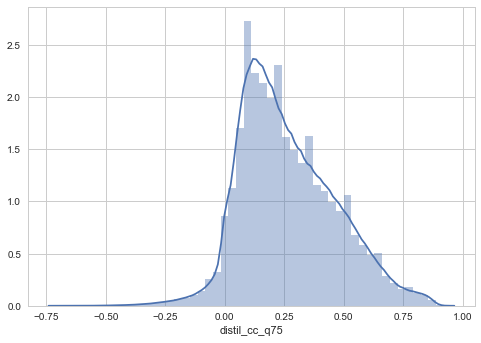

In [13]:
distil_cc_q75_sigs = all_sig_info[all_sig_info.distil_cc_q75 > -1 ]
sns.distplot(distil_cc_q75_sigs.distil_cc_q75);
plt.show()

In [14]:
# n = 150095
gold_sigs = all_sig_info[(all_sig_info['distil_cc_q75'] >= 0.2) 
                         & (all_sig_info['pct_self_rank_q25'] <= 0.05)
                        ].reset_index(drop=True)
gold_sigs.to_csv('checkpoint_files/gold_sigs.csv')

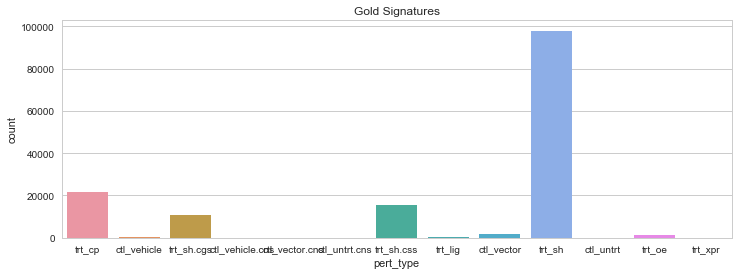

In [15]:
f, ax = plt.subplots(figsize=(12, 4))
sns.countplot(x="pert_type", data=gold_sigs)
plt.title("Gold Signatures")
plt.show()

## Extract gold LINCS cpds

In [16]:
# n_gold_cpd_sigs = 21856
# n_gold_cpds = 4488
gold_cpd_sigs = gold_sigs[gold_sigs['pert_type'] == 'trt_cp'].reset_index(drop=True)

In [17]:
# add inchikeys to table for target lookup
inchi_keys = []
for index, row in log_progress(gold_cpd_sigs.iterrows(), every=1):
    pert_id = row['pert_id']
    inchi_key = pert_info[pert_info['pert_id'] == pert_id].iloc[0]['inchi_key']
    inchi_keys.append(inchi_key)
gold_cpd_sigs['inchi_key'] = pd.Series(inchi_keys)

KeyboardInterrupt: 

## Extract gold LINCS knockdowns

In [ ]:
# n_gold_kd_sigs = 98010
# n_gold_kd_inames = 4344
# n_gold_kd_ids = 15984
gold_kd_sigs = gold_sigs[gold_sigs['pert_type'] == 'trt_sh'].reset_index(drop=True)
kd_genes = gold_kd_sigs['pert_iname'].unique()

# Extracting drug targets from Drugbank

The original Drugbank database is stored in XML format and contains a ton of information that we don't need. Our first goal is to clean this data and create a stripped-down dictionary of drug-target pairings that we can use to lookup the gene targets of drugs tested in the LINCS library. The keys of this dictionary will be the drugs' InChiKeys and the values will be the targets' Hugo Gene Symbols. 

*In the future we may want to use additional metadata from the DrugBank database, such as whether the drugs are inhibitors or activators.*

First we need to clean the data, as the target names are difficult to extract for several reasons: 

* Some drugs are not small molecules but polymers or other macromolecules we are not interested in
* Some drugs have multiple targets with their names stored in a list structure rather than an ordered dictionary
* Some drugs target protein complexes, composed of multiple distinct proteins with different names
* Some target names are missing

In [ ]:
db_db_path = 'data/full_drugbank_database.xml'
drugbank_target_dict = clean_drugbank(db_db_path)

## Looking up DrugBank targets of gold LINCS cpds

In [ ]:
pert_ids = []
pert_inames = []
inchi_keys = []
drugbank_targets = []

for index, row in gold_cpd_sigs.iterrows():
    inchi = row["inchi_key"]
    
    # ignore duplicates
    if inchi not in inchi_keys:
    
        if inchi in drugbank_target_dict.keys(): 
            pert_id = row["pert_id"]
            pert_iname = row["pert_iname"]
            targets = drugbank_target_dict[inchi]

            for target in targets:
                pert_ids.append(pert_id)
                pert_inames.append(pert_iname)
                inchi_keys.append(inchi)
                drugbank_targets.append(target)

gold_cpds_db_targets = pd.DataFrame({'pert_id': pd.Series(pert_ids), 
                                        'pert_iname': pd.Series(pert_inames), 
                                        'Drugbank_target': pd.Series(drugbank_targets),
                                        'inchi_key' : pd.Series(inchi_keys)
                                       })

#### 686 unique LINCS cpds with gold signatures have known targets in DrugBank. 
These correspond to 3239 drug-target pairs. Some cpds have many targets.

In [ ]:
num_target_list = pd.DataFrame({'num_targets': pd.Series(gold_cpds_db_targets['pert_id'].value_counts())})
f, ax = plt.subplots(figsize=(12, 6))
sns.countplot(x="num_targets", data=num_target_list)
plt.ylabel("# of gold cpds")
plt.xlabel("# of targets")
plt.show()

## Lookup ChEMBL targets using REST API

In [ ]:
seen_cpds = []
pert_ids = []
pert_inames = []
inchi_keys = []
chembl_targets = []

for index, row in log_progress(gold_cpd_sigs.iterrows(), every=1):
    pert_id = row['pert_id']
    
    # ignore duplicates
    if pert_id not in seen_cpds:
        seen_cpds.append(pert_id)
        pert_iname = row['pert_iname']
        inchi = row['inchi_key']

        # search CHEMBL using the inchi_key to find corresponding CHEMBL_IDs
        human_target_genes = query_chembl(inchi)

        if len(human_target_genes) > 0:
            for target in human_target_genes:
                pert_ids.append(pert_id)
                pert_inames.append(pert_iname)
                inchi_keys.append(inchi)
                chembl_targets.append(target)

gold_cpds_chembl_targets = pd.DataFrame({'pert_id': pd.Series(pert_ids),
                                         'pert_iname': pd.Series(pert_inames),
                                         'chembl_target': pd.Series(chembl_targets),
                                         'inchi_key' : pd.Series(inchi_keys)
                                        })

#### 434 unique LINCS cpds with gold signatures have known targets in ChEMBL. 
These correspond to 3697 drug-target pairs. Some cpds have many targets.

In [ ]:
num_target_list = pd.DataFrame({'num_targets': pd.Series(gold_cpds_chembl_targets['pert_id'].value_counts())})
f, ax = plt.subplots(figsize=(12, 6))
sns.countplot(x="num_targets", data=num_target_list)
plt.ylabel("# of gold cpds")
plt.xlabel("# of targets")
plt.show()

___
## Combining DrugBank and ChEMBL targets

<br> If DrugBank and ChEMBL had no overlap, we would expect their union to have 1120 unique gold cpds with 6936 drug-target pairs. Instead we find a total of **862 unique gold cpds with 6195 target interactions.** So there is some overlap but the two databases are surprisingly disjoint.

In [ ]:
gold_cpds_targets = pd.concat([gold_cpds_db_targets.rename(index=str, columns={"Drugbank_target": 'target'}),
                               gold_cpds_chembl_targets.rename(index=str, columns={"chembl_target": 'target'}), 
                              ], ignore_index=True).drop_duplicates().reset_index(drop=True)

# Save all the target info to files to save time in the future.
gold_cpds_db_targets.to_csv('checkpoint_files/gold_cpds_db_targets.csv')
gold_cpds_chembl_targets.to_csv('checkpoint_files/gold_cpds_chembl_targets.csv')
gold_cpds_targets.to_csv('checkpoint_files/gold_cpds_targets.csv')

In [ ]:
gold_cpds_targets = pd.DataFrame.from_csv('checkpoint_files/gold_cpds_targets.csv')

num_target_list = pd.DataFrame({'num_targets': pd.Series(gold_cpds_targets['pert_id'].value_counts())})
f, ax = plt.subplots(figsize=(12, 6))
sns.countplot(x="num_targets", data=num_target_list)
plt.ylabel("# of gold cpds")
plt.xlabel("# of targets")
plt.show()

___
## Filter out cpds w/o targets KDs
Now we need to check whether the targets of our gold cpds have gold knockdowns signatures, because we want to use profile correlation to predict targets.


In [ ]:
gold_cpds_targets['target_KD'] = gold_cpds_targets['target'.].isin(kd_genes)
gold_cpds_w_target_kds = gold_cpds_targets[gold_cpds_targets['target_KD']].reset_index(drop=True)

#### 693 unique LINCS cpds with gold signatures have known targets that have their own gold KD signatures.
These correspond to 1995 drug-target pairs.

In [ ]:
num_target_list = pd.DataFrame({'num_targets': pd.Series(gold_cpds_w_target_kds['pert_id'].value_counts())})
f, ax = plt.subplots(figsize=(12, 6))
sns.countplot(x="num_targets", data=num_target_list)
plt.ylabel("# of cpds")
plt.xlabel("# of targets w/ gold kds")
plt.show()

___
# Incorporate Cell line info
<br> We know we have 693 gold compounds with known targets that have their own gold KD signatures. In order to use these signatures for classification we need them to come from the same cell lines.

In [ ]:
gold_cpds_w_target_kds['n_common_cells'] = 0
for i in cell_info_1['cell_id'].values:
    gold_cpds_w_target_kds[i] = False
gold_cpds_w_target_kds.head()

<br> We want to fill in the columns in the table above showing the number of different cell lines for which we have signatures from both the compound and the target knockdown. <br><br>

In [ ]:
for index, row in log_progress(gold_cpds_w_target_kds.iterrows(), every=1):
    cpd_id = row['pert_id']
    target_gene = row['target']
    
    cpd_sigs = gold_cpd_sigs[gold_cpd_sigs['pert_id'] == cpd_id]
    cpd_cells = cpd_sigs['cell_id'].unique()
    
    kd_sigs = gold_kd_sigs[gold_kd_sigs['pert_iname'] == target_gene]
    kd_cells = kd_sigs['cell_id'].unique()
    
    common_cells = np.intersect1d(cpd_cells, kd_cells)
    
    if len(common_cells) > 0:
        gold_cpds_w_target_kds.set_value(index, 'n_common_cells', len(common_cells))
        for cell_line in common_cells:
            gold_cpds_w_target_kds.set_value(index, cell_line, True)

In [ ]:
f, ax = plt.subplots(figsize=(12, 6))
sns.countplot(x="n_common_cells", data=gold_cpds_w_target_kds)
plt.title("# of cells in which both cpd and kd are tested")
plt.xlabel("# cell lines")
plt.ylabel("# compounds")
plt.show()

<br>Many cell lines have no drug-target pairs associated with them. We'll remove these from our consideration, leaving us with 13 cell lines remaining.<br><br>

In [ ]:
for cell_line in gold_cpds_w_target_kds.columns[6:]:
    if not np.any(gold_cpds_w_target_kds[cell_line]):
        gold_cpds_w_target_kds = gold_cpds_w_target_kds.drop(cell_line, axis=1)
gold_cpds_w_target_kds.head()

___
# Find cell lines with the most drug-target pairs
<br>
Now we know which cell lines each drug(treatment) - target(knockdown) pair has been tested in. Next we need to find the subset of k cell-lines that have the most pairs.
<br><br>

In [ ]:
cell_lines = gold_cpds_w_target_kds.columns[6:].values
max_pair_cell_lines = {} # to record cell lines subgroups with max # of pairs for different subgroup sizes
max_cpd_cell_lines = {} # to record cell lines subgroups with max # of unique compounds for different subgroup sizes

for k in log_progress(range(2,12)): # subsets of size k
    max_pair_cell_lines[k] = ([],[],[],None) # (n_common_rows, unique_drugs, common_targets, cell_line_subgroup)
    max_cpd_cell_lines[k] = ([],[],[],None) 
    cell_line_subgroups = list(itertools.combinations(cell_lines,k))
    
    for subgroup in cell_line_subgroups:
        subgroup_cpd_matrix = gold_cpds_w_target_kds[['pert_id', 'target'] + list(subgroup)]
        
        # count number of common cpd-target pairs
        common_pairs = np.logical_and.reduce(subgroup_cpd_matrix[subgroup_cpd_matrix.columns[1:]], axis=1)
        num_common_pairs = np.count_nonzero(common_pairs)
        
        # count number of unique cpds
        true_rows = subgroup_cpd_matrix[common_pairs] # rows in the submatrix with True for all cell lines
        common_cpds = true_rows['pert_id'].unique()
        num_common_cpds = len(common_cpds)
        
        # count number of unique cpds
        common_targets = true_rows['target'].unique()
        num_common_targets = len(common_targets)
        
        # choose max by number of drug-target pairs
        if  num_common_pairs > len(max_pair_cell_lines[k][0]):        
            max_pair_cell_lines[k] = (true_rows, common_cpds, common_targets, subgroup)
          
        # choose max by number of unique drugs
        if num_common_cpds > len(max_cpd_cell_lines[k][1]):
            max_cpd_cell_lines[k] = (true_rows, common_cpds, common_targets, subgroup)

In [ ]:
for n in range(2,9):
    print('\nTop {} cell lines with the most drug-target pairs'.format(n),
          '\nNo. drug-target pairs:\t\t', max_pair_cell_lines[n][0].shape,
          '\nNo. unique drugs:\t\t', len(max_pair_cell_lines[n][1]),
          '\nNo. unique targets:\t\t', len(max_pair_cell_lines[n][2]),
          '\nCell lines:\t\t\t',max_pair_cell_lines[n][3]
         )

The 4 cell lines with the most drug-target pairs in common are ('A375', 'A549', 'MCF7', 'PC3') and they have 244 pairs to learn from, corresponding to 71 unique compounds and 158 unique targets.

___
# Extract gene expression signatures

We'll start just looking at the 71 unique drugs and the 244 associated drug-target pairs tested in four cell lines. Later on we'll expand our analysis to other subsets of cells.

In [ ]:
top_4_cell_lines = list(max_pair_cell_lines[4][3])
top_4_cell_line_cpds = max_pair_cell_lines[4][1]
top_4_cell_line_targets = max_pair_cell_lines[4][2]

___
## Extract cpd sigs of interest 

In [ ]:
# extract sigs from the top 4 cell lines from cpd perturbations we're interested in
top_4_gold_cpd_sigs = gold_cpd_sigs[(gold_cpd_sigs['cell_id'].isin(top_4_cell_lines)) &
                                    (gold_cpd_sigs['pert_id'].isin(top_4_cell_line_cpds))
                                   ]
print("No. of gold cpd signatures from top-4 cell lines: ", len(top_4_gold_cpd_sigs))

So even though there are 71 unique LINCS compounds tested in the top four cell lines with known targets knocked down in the same four cell lines, we have WAY more than 71x4=284 cpd signatures. This means we still have duplicates and we need some way to define a representative signature.

We'll follow the CMAP guidance and select the signature with the highest **TAS**:

*Due to the redundancy of the CMap database, meaning that some perturbagens have many signatures even within the same cell line, it is convenient to identify a single ‘exemplar’ signature for each perturbagen in each cell line. These signatures are specifically designated for further analysis, such as ICC and aggregate TAS. Exemplar signatures were selected according to the following process. For each perturbagen in each cell line:
If possible, consider only signatures with between 2 and 6 replicates.
Within these signatures, select the one with highest transcriptional activity score (TAS). See tas for more details.
If there are no signatures that have between 2 and 6 replicates, simply select the one with highest TAS.*
<br>
### Select representatives

In [ ]:
repr_top_4_gold_cpd_sigs = pd.DataFrame(columns=top_4_gold_cpd_sigs.columns)

for pert_id in log_progress(top_4_cell_line_cpds):
    for cell_id in top_4_cell_lines:
        candidate_sigs = top_4_gold_cpd_sigs[(top_4_gold_cpd_sigs.pert_id == pert_id) &
                                             (top_4_gold_cpd_sigs.cell_id == cell_id)
                                            ]
        repr_sig = candidate_sigs.loc[candidate_sigs['tas'].idxmax()]
        repr_top_4_gold_cpd_sigs = repr_top_4_gold_cpd_sigs.append(repr_sig)

### Extract 71 cpd gene expression vectors from GCTX

In [ ]:
phase_1_sig_ids = parse('data/GSE92742_Broad_LINCS_Level5_COMPZ.MODZ_n473647x12328.gctx', col_meta_only=True).index.values
phase_2_sig_ids = parse('data/GSE70138_Broad_LINCS_Level5_COMPZ_n118050x12328_2017-03-06.gctx', col_meta_only=True).index.values

In [ ]:
# The GCTX files encode the sig IDS as strings of byte strings (why????) so we have to deal with that
top_4_cpd_sig_ids = [ str(s.encode('UTF8')) for s  in repr_top_4_gold_cpd_sigs.sig_id.values ]
phase_1_top_4_cpd_sig_ids = [ s for s in top_4_cpd_sig_ids if s in phase_1_sig_ids ]
phase_2_top_4_cpd_sig_ids = [ s for s in top_4_cpd_sig_ids if s in phase_2_sig_ids ]

In [ ]:
# extract the actual signatures
phase_1_top_4_cpd_sigs = parse('data/GSE92742_Broad_LINCS_Level5_COMPZ.MODZ_n473647x12328.gctx', cid=phase_1_top_4_cpd_sig_ids).data_df
phase_2_top_4_cpd_sigs = parse('data/GSE70138_Broad_LINCS_Level5_COMPZ_n118050x12328_2017-03-06.gctx', cid=phase_2_top_4_cpd_sig_ids).data_df
phase_2_top_4_cpd_sigs.rename(lambda x: x[2:-1], inplace=True)
top_4_cpd_sigs = pd.concat([phase_1_top_4_cpd_sigs, phase_2_top_4_cpd_sigs], axis=1)

In [ ]:
# discard all but landmark gene values
top_4_cpd_lm_sigs = top_4_cpd_sigs[top_4_cpd_sigs.index.isin(lm_gene_ids)].sort_index().copy()
top_4_cpd_lm_sigs.head()

In [ ]:
# reformat the sig_ids so they are nice strings
top_4_cpd_lm_sigs = top_4_cpd_lm_sigs.T.rename(lambda x: x.lstrip('b\'').rstrip('\'')).T

___
## Extract target-KD sigs of interest 

In [ ]:
# extract sigs from the top 4 cell lines from gene KDs we're interested in
top_4_gold_target_kd_sigs = gold_kd_sigs[(gold_kd_sigs['cell_id'].isin(top_4_cell_lines)) &
                                         (gold_kd_sigs['pert_iname'].isin(top_4_cell_line_targets))
                                        ]
print("No. of gold target KD signatures from top-4 cell lines: ", len(top_4_gold_target_kd_sigs))

Again, we have more than 158x4=632 target signatures. We'll follow the CMAP guidance and select the signature with the highest **TAS**

#### Select representatives

In [ ]:
repr_top_4_gold_target_kd_sigs = pd.DataFrame(columns=top_4_gold_target_kd_sigs.columns)

for pert_iname in log_progress(top_4_cell_line_targets):
    for cell_id in top_4_cell_lines:
        candidate_sigs = top_4_gold_target_kd_sigs[(top_4_gold_target_kd_sigs.pert_iname == pert_iname) &
                                                   (top_4_gold_target_kd_sigs.cell_id == cell_id)
                                                  ]
        repr_sig = candidate_sigs.loc[candidate_sigs['tas'].idxmax()]
        repr_top_4_gold_target_kd_sigs = repr_top_4_gold_target_kd_sigs.append(repr_sig)

### Extract KD gene expression vectors from GCTX

In [ ]:
# The GCTX files encode the sig IDS as strings of byte strings (why????) so we have to deal with that
top_4_target_kd_sig_ids = [ str(s.encode('UTF8')) for s  in repr_top_4_gold_target_kd_sigs.sig_id.values ]
phase_1_top_4_target_kd_sig_ids = [ s for s in top_4_target_kd_sig_ids if s in phase_1_sig_ids ]
phase_2_top_4_target_kd_sig_ids = [ s for s in top_4_target_kd_sig_ids if s in phase_2_sig_ids ]
# no knockdowns in phase 2 data so we'll just go with phase 1 data

In [ ]:
# read in the data
top_4_target_kd_sigs = parse('data/GSE92742_Broad_LINCS_Level5_COMPZ.MODZ_n473647x12328.gctx', cid=phase_1_top_4_target_kd_sig_ids).data_df

In [ ]:
# discard non-landmark gene expression scores
top_4_target_kd_lm_sigs = top_4_target_kd_sigs[top_4_target_kd_sigs.index.isin(lm_gene_ids)].sort_index().copy()

In [ ]:
# reformat the sig_ids so they are nice strings
top_4_target_kd_lm_sigs = top_4_target_kd_lm_sigs.T.rename(lambda x: x.lstrip('b\'').rstrip('\'')).T
top_4_target_kd_lm_sigs.to_csv('checkpoint_files/top_4_target_kd_lm_sigs.csv')

In [ ]:
top_4_target_kd_lm_sigs.head()

___
## Extract all KD sigs from the top-4 cell lines (not just known targets)

In [ ]:
# extract sigs from the top 4 cell lines from gene KDs we're interested in
top_4_gold_kd_sigs = gold_kd_sigs[(gold_kd_sigs['cell_id'].isin(top_4_cell_lines))]
print("No. of gold KD signatures from top-4 cell lines: ", len(top_4_gold_kd_sigs))

In [ ]:
top_4_gold_kd_genes = top_4_gold_kd_sigs['pert_iname'].unique()
print("No. of gold KD genes from top-4 cell lines: ", len(top_4_gold_kd_genes))

In [ ]:
# select representatives with highest TAS
repr_top_4_gold_kd_sigs = pd.DataFrame(columns=top_4_gold_kd_sigs.columns)

for pert_iname in log_progress(top_4_gold_kd_genes):
    
    # make sure that the KD has been performed in all 4 cell lines
    kd_sigs = top_4_gold_kd_sigs.query('pert_iname == "{}"'.format(pert_iname))
    num_kd_cells = len(kd_sigs['cell_id'].unique())
    if num_kd_cells == 4:
    
        for cell_id in top_4_cell_lines:
            candidate_sigs = top_4_gold_kd_sigs[(top_4_gold_kd_sigs.pert_iname == pert_iname) &
                                                (top_4_gold_kd_sigs.cell_id == cell_id)]
            repr_sig = candidate_sigs.loc[candidate_sigs['tas'].idxmax()]
            repr_top_4_gold_kd_sigs = repr_top_4_gold_kd_sigs.append(repr_sig)

In [ ]:
top_4_repr_kd_genes = repr_top_4_gold_kd_sigs['pert_iname'].unique()
print("No. of gold KD genes from top-4 cell lines: ", len(top_4_repr_kd_genes))

In [ ]:
# The GCTX files encode the sig IDS as strings of byte strings (why????) so we have to deal with that
top_4_kd_sig_ids = [ str(s.encode('UTF8')) for s in repr_top_4_gold_kd_sigs.sig_id.values ]
phase_1_top_4_kd_sig_ids = [ s for s in top_4_kd_sig_ids if s in phase_1_sig_ids ]
#phase_2_top_4_kd_sig_ids = [ s for s in top_4_kd_sig_ids if s in phase_2_sig_ids ]
# no knockdowns in phase 2 data so we'll just go with phase 1 data

In [ ]:
len(phase_1_top_4_kd_sig_ids) / 4.

In [ ]:
# read in the data
top_4_kd_sigs = parse('data/GSE92742_Broad_LINCS_Level5_COMPZ.MODZ_n473647x12328.gctx', cid=phase_1_top_4_kd_sig_ids).data_df

In [ ]:
# discard non-landmark gene expression scores
top_4_kd_lm_sigs = top_4_kd_sigs[top_4_kd_sigs.index.isin(lm_gene_ids)].sort_index().copy()

In [ ]:
# reformat the sig_ids so they are nice strings
top_4_kd_lm_sigs = top_4_kd_lm_sigs.T.rename(lambda x: x.lstrip('b\'').rstrip('\'')).T

___
## Collect data for next phase of processing

In [ ]:
print(repr_top_4_gold_kd_sigs.shape)
print(top_4_kd_lm_sigs.shape)

repr_top_4_gold_kd_sigs.to_csv('checkpoint_files/repr_top_4_gold_kd_sigs.csv')
top_4_kd_lm_sigs.to_csv('checkpoint_files/top_4_kd_lm_sigs.csv')

In [ ]:
print(repr_top_4_gold_cpd_sigs.shape)
print(top_4_cpd_lm_sigs.shape)

repr_top_4_gold_cpd_sigs.to_csv('checkpoint_files/repr_top_4_gold_cpd_sigs.csv')
top_4_cpd_lm_sigs.to_csv('checkpoint_files/top_4_cpd_lm_sigs.csv')

In [ ]:
top_4_known_interactions = max_pair_cell_lines[4][0][['pert_id','target']].copy()
top_4_known_interactions.to_csv('checkpoint_files/top_4_known_interactions.csv')

___
# Figure out which signatures pair together
<br> 
First we'll construct positive pairs, representing true drug-target relationships.

In [ ]:
# first we'll assemble our positive training examples
top_4_pairings = max_pair_cell_lines[4][0]
top_4_pos_pair_sigs = top_4_pairings[['pert_id','target']].reset_index(drop=True)
top_4_pos_pair_sigs['label'] = pd.Series(1.0, index = top_4_pos_pair_sigs.index)

# initialize empty columns to hold signature ids
for cell_line in top_4_cell_lines:
    cpd_col = 'cpd_' + cell_line
    target_col = 'target_' + cell_line
    top_4_pos_pair_sigs[cpd_col] = pd.Series('', index=top_4_pos_pair_sigs.index)
    top_4_pos_pair_sigs[target_col] = pd.Series('', index=top_4_pos_pair_sigs.index)

# now find the relevant sig ids for each pair
for index, pair in log_progress(top_4_pos_pair_sigs.iterrows(), every=1):
    cpd = pair['pert_id']
    target = pair['target']
    
    # get the sig info for the drug and target experiments in the four cell lines
    cpd_sig_info = repr_top_4_gold_cpd_sigs[repr_top_4_gold_cpd_sigs['pert_id'] == cpd].sort_values(['cell_id'])
    target_sig_info = repr_top_4_gold_target_kd_sigs[repr_top_4_gold_target_kd_sigs['pert_iname'] == target].sort_values(['cell_id'])
    
    # populate the values in the original datatable
    for cell_line in cpd_sig_info['cell_id']:
        cpd_col = 'cpd_' + cell_line
        target_col = 'target_' + cell_line
        
        cpd_sig_id = cpd_sig_info[cpd_sig_info.cell_id == cell_line]['sig_id'].values[0]
        target_sig_id = target_sig_info[target_sig_info.cell_id == cell_line]['sig_id'].values[0]
        
        top_4_pos_pair_sigs.set_value(index, cpd_col, cpd_sig_id)
        top_4_pos_pair_sigs.set_value(index, target_col, target_sig_id)
    

In [ ]:
top_4_pos_pair_sigs

## Construct negative training examples (using Targets ONLY)
Now we'll construct negative pairs, representing false drug-target mappings. We need these negative examples for training, 

In [ ]:
pert_ids = []
targets = []

for cpd in top_4_cell_line_cpds:
    true_cpd_targets = top_4_pairings[top_4_pairings['pert_id'] == cpd]['target'].values

    for target in top_4_cell_line_targets:
        if target not in true_cpd_targets:
            pert_ids.append(cpd)
            targets.append(target)

In [ ]:
top_4_neg_pair_sigs = pd.DataFrame({'pert_id': pd.Series(pert_ids), 'target' : pd.Series(targets)})
top_4_neg_pair_sigs['label'] = pd.Series(-1.0, index = top_4_neg_pair_sigs.index)


# initialize empty columns to hold signature ids
for cell_line in top_4_cell_lines:
    cpd_col = 'cpd_' + cell_line
    target_col = 'target_' + cell_line
    top_4_neg_pair_sigs[cpd_col] = pd.Series('', index=top_4_neg_pair_sigs.index)
    top_4_neg_pair_sigs[target_col] = pd.Series('', index=top_4_neg_pair_sigs.index)

# now find the relevant sig ids for each pair
for index, pair in log_progress(top_4_neg_pair_sigs.iterrows(), every=1):
    cpd = pair['pert_id']
    target = pair['target']
    
    # get the sig info for the drug and target experiments in the four cell lines
    cpd_sig_info = repr_top_4_gold_cpd_sigs[repr_top_4_gold_cpd_sigs['pert_id'] == cpd].sort_values(['cell_id'])
    target_sig_info = repr_top_4_gold_target_kd_sigs[repr_top_4_gold_target_kd_sigs['pert_iname'] == target].sort_values(['cell_id'])
    
    # populate the values in the original datatable
    for cell_line in cpd_sig_info['cell_id']:
        cpd_col = 'cpd_' + cell_line
        target_col = 'target_' + cell_line
        
        cpd_sig_id = cpd_sig_info[cpd_sig_info.cell_id == cell_line]['sig_id'].values[0]
        target_sig_id = target_sig_info[target_sig_info.cell_id == cell_line]['sig_id'].values[0]
        
        top_4_neg_pair_sigs.set_value(index, cpd_col, cpd_sig_id)
        top_4_neg_pair_sigs.set_value(index, target_col, target_sig_id)
    

In [ ]:
top_4_neg_pair_sigs.shape

## Construct negative training examples (using Targets ONLY)

## Assemble training examples

In [ ]:
top_4_all_pair_sigs = pd.concat([top_4_pos_pair_sigs, top_4_neg_pair_sigs], ignore_index=True)
top_4_all_pair_sigs.to_csv('checkpoint_files/top_4_all_pair_sig_ids.csv')